## ** Competition Overview**

For this Kernel, I decided to give it a shoot at the drivendata.org competition: "**Richter's Predictor: Modeling Earthquake Damage.**" Based on aspects of building location and construction, your goal is to predict the level of damage to buildings caused by the 2015 Gorkha earthquake in Nepal.

<img src="https://s3.amazonaws.com/drivendata-public-assets/nepal-quake-bm-2.JPG" width="500">

The data was collected through surveys by the Central Bureau of Statistics that work under the National Planning Commission Secretariat of Nepal. This survey is one of the largest post-disaster datasets ever collected, containing valuable information on earthquake impacts, household conditions, and socio-economic-demographic statistics.

## **Import Libraries**

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.metrics import f1_score as score #Scoring metric for the competition
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import time
import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
sns.set_palette("Set2")
sns.set_style("ticks")

## **Import Data**

In [2]:
train_labels = pd.read_csv("target_values.csv")
train_values = pd.read_csv("input_features.csv")
test_values = pd.read_csv("input_features.csv")

# **Exploratory Data Analysis**

Our main objectives for any Exploratory Data Analysis should be the following:
* Check for missing values
* Know the data type of each variable
* Observe the distribution of the data
* Identify and deal with outliers
* Make relevant conclusions about the data

In [3]:
print("# Train Values: {}".format(train_values.shape))
print("# Train Labels: {}".format(train_labels.shape))
print("# Test Values: {}".format(test_values.shape))

# Train Values: (260601, 39)
# Train Labels: (260601, 2)
# Test Values: (260601, 39)


In [4]:
train_labels.head()

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3


In [5]:
train_values.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [6]:
test_values.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


## **Missing Values**

In [7]:
train_values.isnull().sum() * 100 / len(train_values)

building_id                               0.0
geo_level_1_id                            0.0
geo_level_2_id                            0.0
geo_level_3_id                            0.0
count_floors_pre_eq                       0.0
age                                       0.0
area_percentage                           0.0
height_percentage                         0.0
land_surface_condition                    0.0
foundation_type                           0.0
roof_type                                 0.0
ground_floor_type                         0.0
other_floor_type                          0.0
position                                  0.0
plan_configuration                        0.0
has_superstructure_adobe_mud              0.0
has_superstructure_mud_mortar_stone       0.0
has_superstructure_stone_flag             0.0
has_superstructure_cement_mortar_stone    0.0
has_superstructure_mud_mortar_brick       0.0
has_superstructure_cement_mortar_brick    0.0
has_superstructure_timber         

In [8]:
train_labels.isnull().sum() * 100 / len(train_values)

building_id     0.0
damage_grade    0.0
dtype: float64

In [9]:
test_values.isnull().sum() * 100 / len(train_values)

building_id                               0.0
geo_level_1_id                            0.0
geo_level_2_id                            0.0
geo_level_3_id                            0.0
count_floors_pre_eq                       0.0
age                                       0.0
area_percentage                           0.0
height_percentage                         0.0
land_surface_condition                    0.0
foundation_type                           0.0
roof_type                                 0.0
ground_floor_type                         0.0
other_floor_type                          0.0
position                                  0.0
plan_configuration                        0.0
has_superstructure_adobe_mud              0.0
has_superstructure_mud_mortar_stone       0.0
has_superstructure_stone_flag             0.0
has_superstructure_cement_mortar_stone    0.0
has_superstructure_mud_mortar_brick       0.0
has_superstructure_cement_mortar_brick    0.0
has_superstructure_timber         

The dataset looks very clean and we don't seem to have any missing data.

## **Data Types**

In [10]:
train_values.dtypes

building_id                                int64
geo_level_1_id                             int64
geo_level_2_id                             int64
geo_level_3_id                             int64
count_floors_pre_eq                        int64
age                                        int64
area_percentage                            int64
height_percentage                          int64
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int64
has_superstructure_mud_mortar_stone        int64
has_superstructure_stone_flag              int64
has_superstructure_cement_mortar_stone     int64
has_superstructure_mud_mortar_brick        int64
has_superstructure_c

In [11]:
train_labels.dtypes

building_id     int64
damage_grade    int64
dtype: object

In [12]:
test_values.dtypes

building_id                                int64
geo_level_1_id                             int64
geo_level_2_id                             int64
geo_level_3_id                             int64
count_floors_pre_eq                        int64
age                                        int64
area_percentage                            int64
height_percentage                          int64
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int64
has_superstructure_mud_mortar_stone        int64
has_superstructure_stone_flag              int64
has_superstructure_cement_mortar_stone     int64
has_superstructure_mud_mortar_brick        int64
has_superstructure_c

## **Data Distribution**

Let's start by taking a look at how balanced our datasets really is.

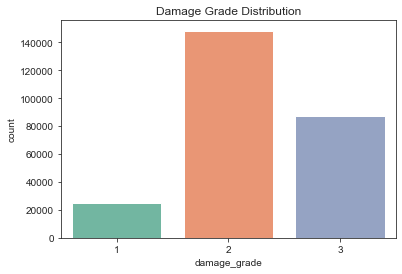

In [13]:
sns.countplot(x="damage_grade", data=train_labels)
plt.title("Damage Grade Distribution")
plt.show()

From the previous plot, it is easy to see that our dataset is very imbalanced. The reason why this dataset is imbalanced could be due to the fact that the data was collected after the 2015 Nepal's Earthquake, and it is very likely that the damage grade of the buildings is highly correlated to the intensity of the earthquake. It is important to mention that decision trees and random forests are extremely sensitive to imbalanced data. 

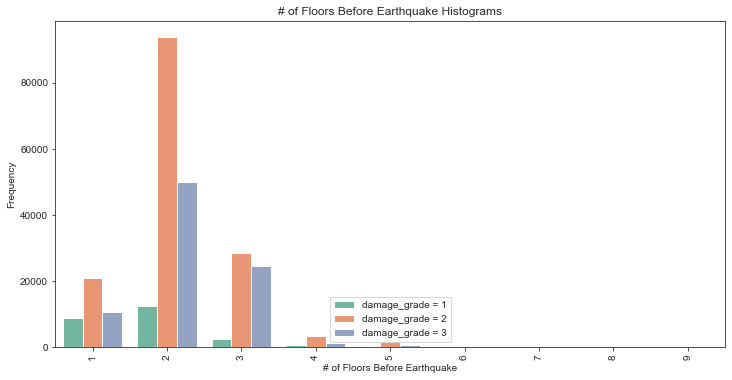

In [14]:
plt.figure(figsize=(12,6))
sns.countplot(train_values["count_floors_pre_eq"], hue=train_labels["damage_grade"])
plt.ylabel("Frequency")
plt.xlabel("# of Floors Before Earthquake")
plt.xticks(rotation=90)
plt.title("# of Floors Before Earthquake Histograms")
plt.legend(["damage_grade = 1","damage_grade = 2","damage_grade = 3"])
plt.show()

There are buildings in the dataset with up to 9 floors, but the majority of the affect had only 2.

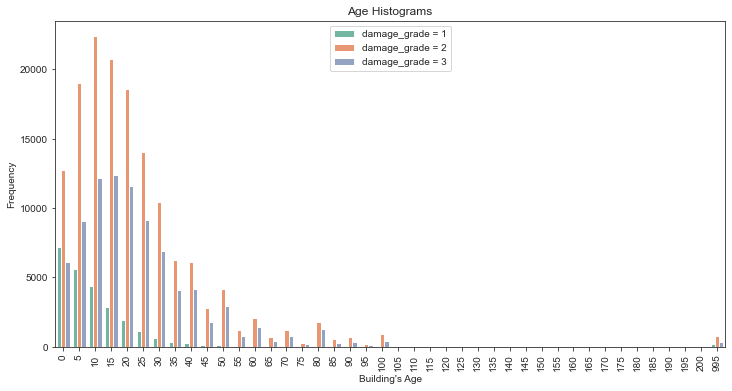

In [15]:
plt.figure(figsize=(12,6))
sns.countplot(x=train_values["age"],hue=train_labels["damage_grade"])
plt.ylabel("Frequency")
plt.xlabel("Building's Age")
plt.xticks(rotation=90)
plt.title("Age Histograms")
plt.legend(["damage_grade = 1","damage_grade = 2","damage_grade = 3"])
plt.show()

We have buildings around 995 years old, which at first glance seems like a error in the collection of data. After a quick Google search, I was able to determine that buildings in Nepal can be that old. Nevertheless, we still have to deal with the outliers.

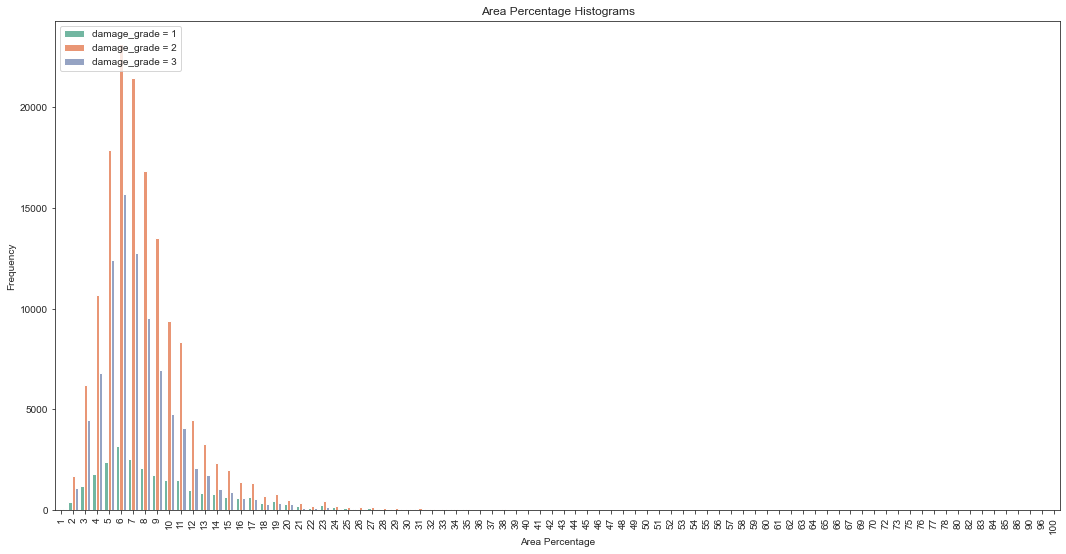

In [16]:
plt.figure(figsize=(18,9))
sns.countplot(x=train_values["area_percentage"],hue=train_labels["damage_grade"])
plt.ylabel("Frequency")
plt.xlabel("Area Percentage")
plt.xticks(rotation=90)
plt.title("Area Percentage Histograms")
plt.legend(["damage_grade = 1","damage_grade = 2","damage_grade = 3"])
plt.show()

The normalized area of the building footprint is less than 20% for most buildings. It is important to mention that some values go up to 100%, so it is important for us to take care of the outliers of this feature.

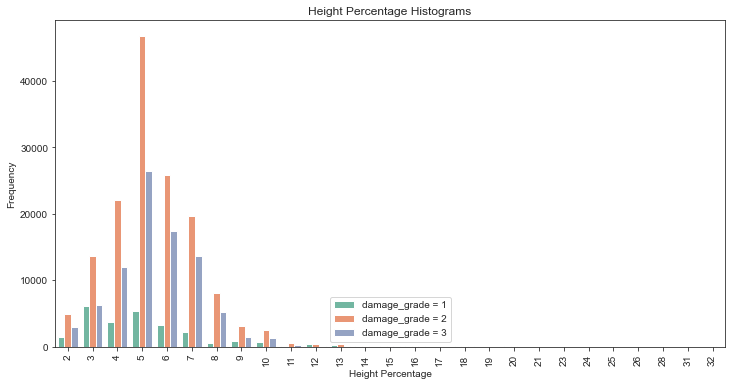

In [17]:
plt.figure(figsize=(12,6))
sns.countplot(x=train_values["height_percentage"],hue=train_labels["damage_grade"])
plt.ylabel("Frequency")
plt.xlabel("Height Percentage")
plt.xticks(rotation=90)
plt.title("Height Percentage Histograms")
plt.legend(["damage_grade = 1","damage_grade = 2","damage_grade = 3"])
plt.show()

Once again, we have another variable that needs to have its outliers removed. Most of the data for this feature is less than 10%, but we have some buildings with values up to 32%.

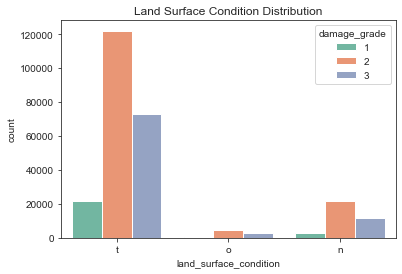

In [18]:
sns.countplot(x = train_values["land_surface_condition"], hue = train_labels["damage_grade"])
plt.title("Land Surface Condition Distribution")
plt.show()

This is a categorical variable that indicates the surface condition of the land where the building was built. Possible values: n, o, t.

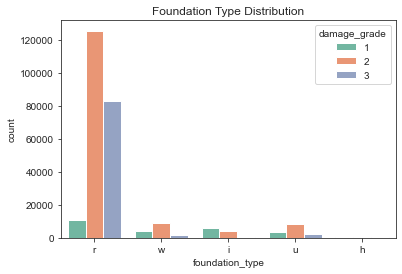

In [19]:
sns.countplot(x = train_values["foundation_type"], hue = train_labels["damage_grade"])
plt.title("Foundation Type Distribution")
plt.show()

This is a categorical variable that indicates the type of foundation used while building. Possible values: h, i, r, u, w.

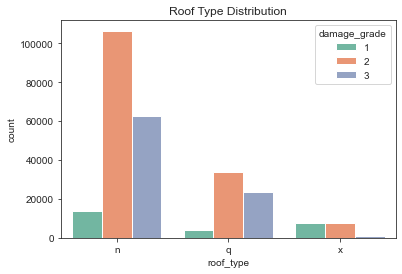

In [20]:
sns.countplot(x = train_values["roof_type"], hue = train_labels["damage_grade"])
plt.title("Roof Type Distribution")
plt.show()

This is a categorical variable that indicates the type of roof used while building. Possible values: n, q, x

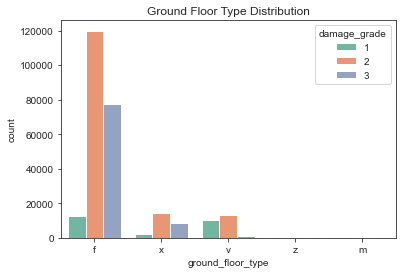

In [21]:
sns.countplot(x = train_values["ground_floor_type"], hue = train_labels["damage_grade"])
plt.title("Ground Floor Type Distribution")
plt.show()

This is a categorical variable that indicates the type of the ground floor. Possible values: f, m, v, x, z.

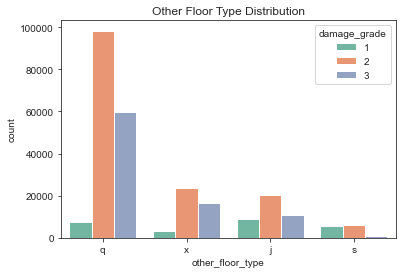

In [22]:
sns.countplot(x = train_values["other_floor_type"], hue = train_labels["damage_grade"])
plt.title("Other Floor Type Distribution")
plt.show()

This is a categorical variable that indicates the type of constructions used in higher than the ground floors (except of roof). Possible values: j, q, s, x.

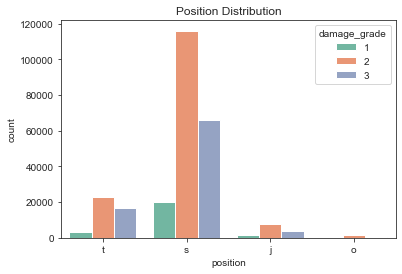

In [23]:
sns.countplot(x = train_values["position"], hue = train_labels["damage_grade"])
plt.title("Position Distribution")
plt.show()

This is a categorical variable that indicates the position of the building. Possible values: j, o, s, t.

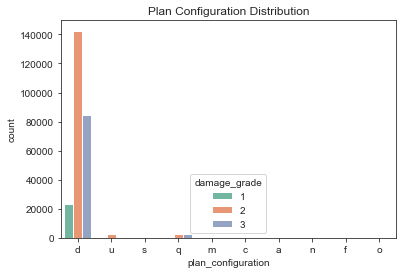

In [24]:
sns.countplot(x = train_values["plan_configuration"], hue = train_labels["damage_grade"])
plt.title("Plan Configuration Distribution")
plt.show()

This is a categorical variable that indicates the building plan configuration. Possible values: a, c, d, f, m, n, o, q, s, u.

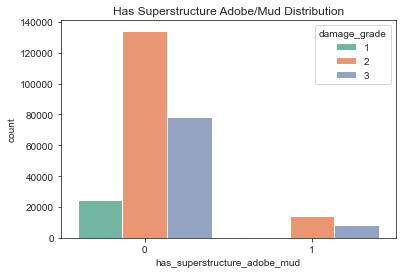

In [25]:
sns.countplot(x = train_values["has_superstructure_adobe_mud"], hue = train_labels["damage_grade"])
plt.title("Has Superstructure Adobe/Mud Distribution")
plt.show()

This is a flag variable that indicates if the superstructure was made of Adobe/Mud.

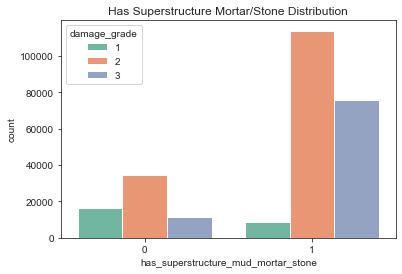

In [26]:
sns.countplot(x = train_values["has_superstructure_mud_mortar_stone"], hue = train_labels["damage_grade"])
plt.title("Has Superstructure Mortar/Stone Distribution")
plt.show()

This is a flag variable that indicates if the superstructure was made of Mud Mortar - Stone.

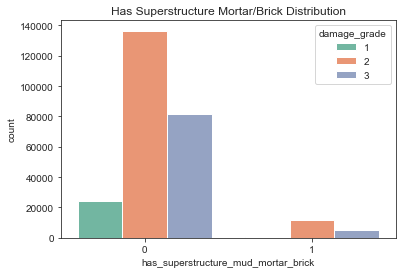

In [27]:
sns.countplot(x = train_values["has_superstructure_mud_mortar_brick"], hue = train_labels["damage_grade"])
plt.title("Has Superstructure Mortar/Brick Distribution")
plt.show()

This is a flag variable that indicates if the superstructure was made of Mud Mortar - Brick.

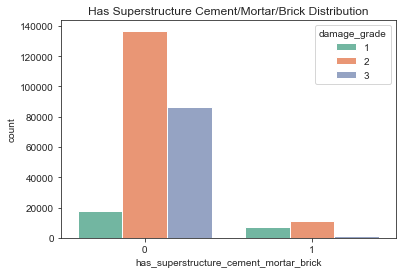

In [28]:
sns.countplot(x = train_values["has_superstructure_cement_mortar_brick"], hue = train_labels["damage_grade"])
plt.title("Has Superstructure Cement/Mortar/Brick Distribution")
plt.show()

This is a flag variable that indicates if the superstructure was made of Cement Mortar - Brick.

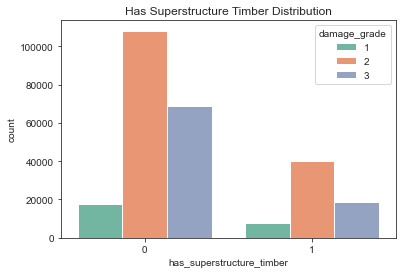

In [29]:
sns.countplot(x = train_values["has_superstructure_timber"], hue = train_labels["damage_grade"])
plt.title("Has Superstructure Timber Distribution")
plt.show()

This is a flag variable that indicates if the superstructure was made of Timber.

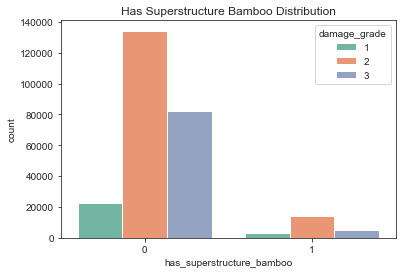

In [30]:
sns.countplot(x = train_values["has_superstructure_bamboo"], hue = train_labels["damage_grade"])
plt.title("Has Superstructure Bamboo Distribution")
plt.show()

This is a flag variable that indicates if the superstructure was made of Bamboo.

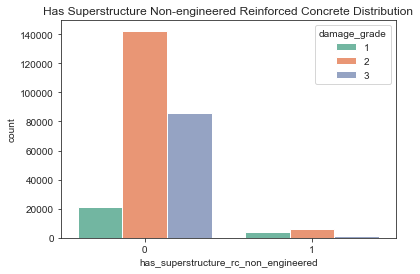

In [31]:
sns.countplot(x = train_values["has_superstructure_rc_non_engineered"], hue = train_labels["damage_grade"])
plt.title("Has Superstructure Non-engineered Reinforced Concrete Distribution")
plt.show()

This is a flag variable that indicates if the superstructure was made of non-engineered reinforced concrete.

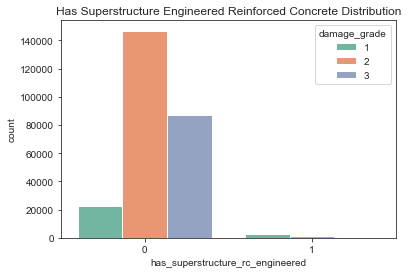

In [32]:
sns.countplot(x = train_values["has_superstructure_rc_engineered"], hue = train_labels["damage_grade"])
plt.title("Has Superstructure Engineered Reinforced Concrete Distribution")
plt.show()

This is a flag variable that indicates if the superstructure was made of engineered reinforced concrete.

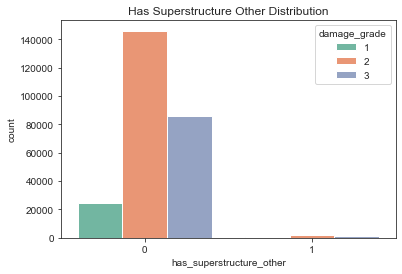

In [33]:
sns.countplot(x = train_values["has_superstructure_other"], hue = train_labels["damage_grade"])
plt.title("Has Superstructure Other Distribution")
plt.show()

This is a flag variable that indicates if the superstructure was made of any other material.

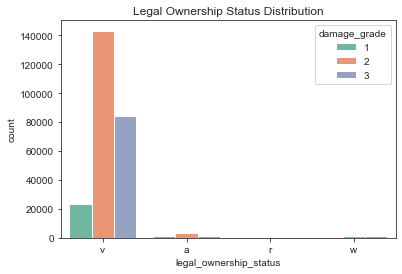

In [34]:
sns.countplot(x = train_values["legal_ownership_status"], hue = train_labels["damage_grade"])
plt.title("Legal Ownership Status Distribution")
plt.show()

This is a categorical variable that indicates the legal ownership status of the land where building was built. Possible values: a, r, v, w.

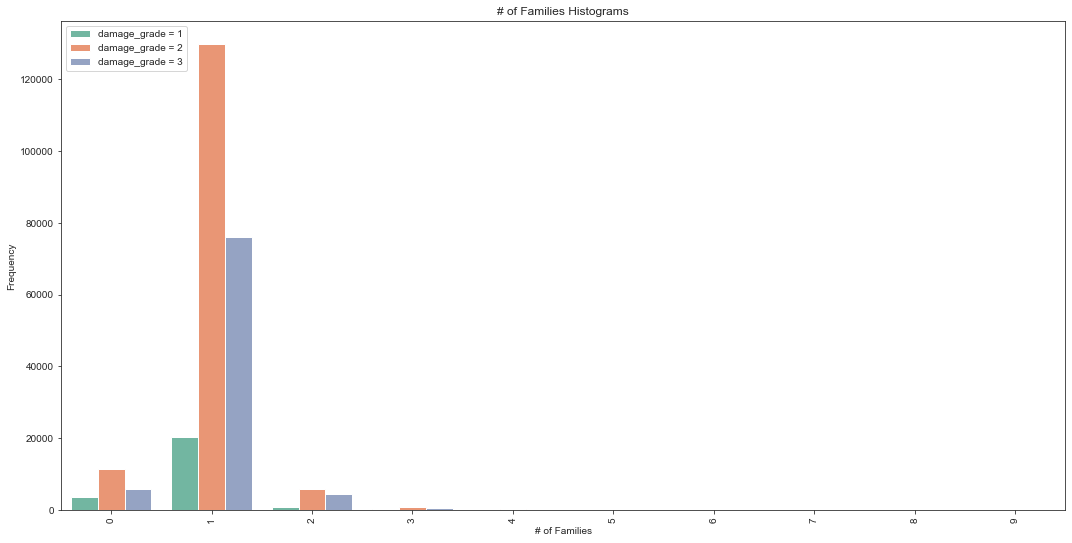

In [35]:
plt.figure(figsize=(18,9))
sns.countplot(x=train_values["count_families"],hue=train_labels["damage_grade"])
plt.ylabel("Frequency")
plt.xlabel("# of Families")
plt.xticks(rotation=90)
plt.title("# of Families Histograms")
plt.legend(["damage_grade = 1","damage_grade = 2","damage_grade = 3"])
plt.show()

Most of the buildings had only 1 familiy living in them. We also have buildings were up to 9 families were living in, this buildings could be the same as those buildings with 9 floors. 

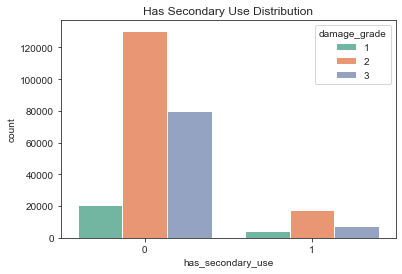

In [36]:
sns.countplot(x = train_values["has_secondary_use"], hue = train_labels["damage_grade"])
plt.title("Has Secondary Use Distribution")
plt.show()

This is a flag variable that indicates if the building was used for any secondary purpose.

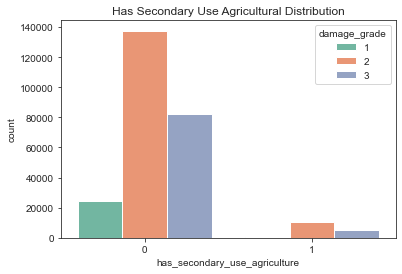

In [37]:
sns.countplot(x = train_values["has_secondary_use_agriculture"], hue = train_labels["damage_grade"])
plt.title("Has Secondary Use Agricultural Distribution")
plt.show()

This is a flag variable that indicates if the building was used for agricultural purposes.

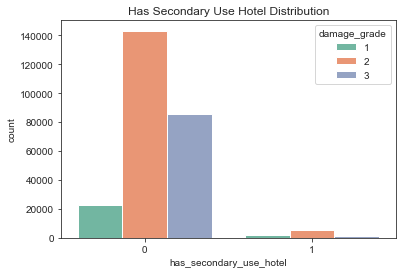

In [38]:
sns.countplot(x = train_values["has_secondary_use_hotel"], hue = train_labels["damage_grade"])
plt.title("Has Secondary Use Hotel Distribution")
plt.show()

This is a flag variable that indicates if the building was used as a hotel.

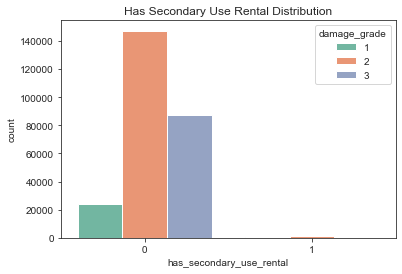

In [39]:
sns.countplot(x = train_values["has_secondary_use_rental"], hue = train_labels["damage_grade"])
plt.title("Has Secondary Use Rental Distribution")
plt.show()

This is a flag variable that indicates if the building was used for rental purposes.

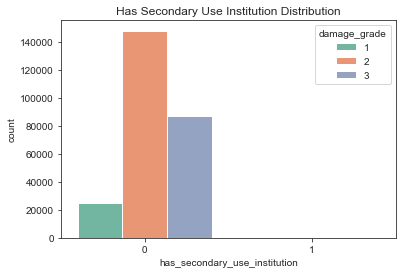

In [40]:
sns.countplot(x = train_values["has_secondary_use_institution"], hue = train_labels["damage_grade"])
plt.title("Has Secondary Use Institution Distribution")
plt.show()

This is a flag variable that indicates if the building was used as a location of any institution.

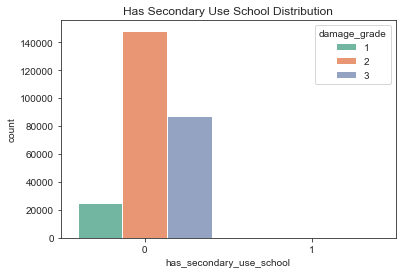

In [41]:
sns.countplot(x = train_values["has_secondary_use_school"], hue = train_labels["damage_grade"])
plt.title("Has Secondary Use School Distribution")
plt.show()

This is a flag variable that indicates if the building was used as a school.

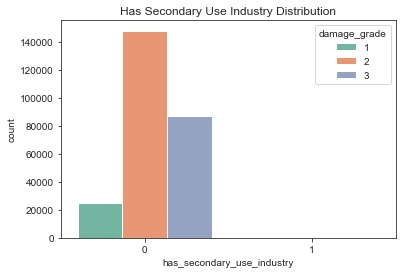

In [42]:
sns.countplot(x = train_values["has_secondary_use_industry"], hue = train_labels["damage_grade"])
plt.title("Has Secondary Use Industry Distribution")
plt.show()

This is a flag variable that indicates if the building was used for industrial purposes.

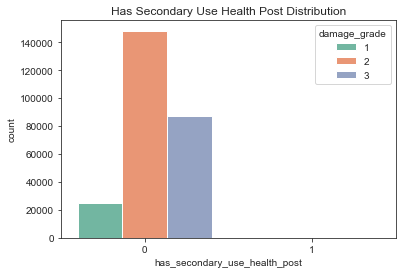

In [43]:
sns.countplot(x = train_values["has_secondary_use_health_post"], hue = train_labels["damage_grade"])
plt.title("Has Secondary Use Health Post Distribution")
plt.show()

This is a flag variable that indicates if the building was used as a health post.

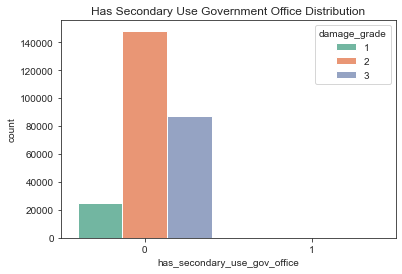

In [44]:
sns.countplot(x = train_values["has_secondary_use_gov_office"], hue = train_labels["damage_grade"])
plt.title("Has Secondary Use Government Office Distribution")
plt.show()

This is a flag variable that indicates if the building was used fas a government office.

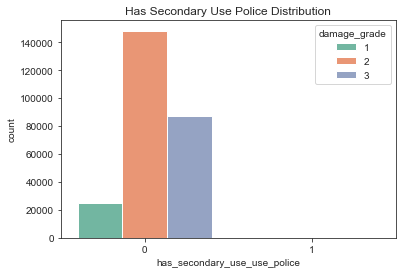

In [45]:
sns.countplot(x = train_values["has_secondary_use_use_police"], hue = train_labels["damage_grade"])
plt.title("Has Secondary Use Police Distribution")
plt.show()

This is a flag variable that indicates if the building was used as a police station.

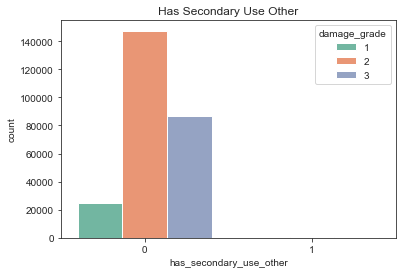

In [46]:
sns.countplot(x = train_values["has_secondary_use_other"], hue = train_labels["damage_grade"])
plt.title("Has Secondary Use Other")
plt.show()

This is a flag variable that indicates if the building was secondarily used for other purposes.

## **Outliers**

Random Forests are a machine learning model based on decision trees, which are believed to perform strong even when the data contains outliers. However, this is a common misconception...

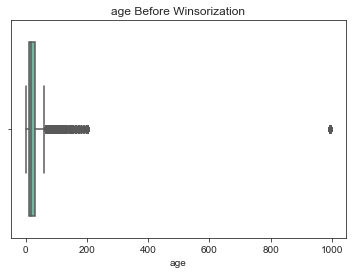

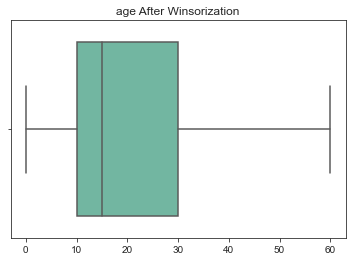

In [47]:
#Data source
name = "age"
data = train_values[name]

#Before winsorization
sns.boxplot(data)
plt.title("{} Before Winsorization".format(name))
plt.show()

#Winsorization
winsorized_data = winsorize(data,(0, 0.05))

#After winsorization
sns.boxplot(winsorized_data)
plt.title("{} After Winsorization".format(name))
plt.show()

#Replace data in dataset
train_values[name] = winsorized_data

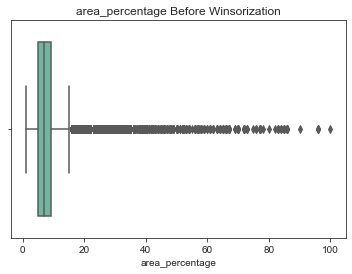

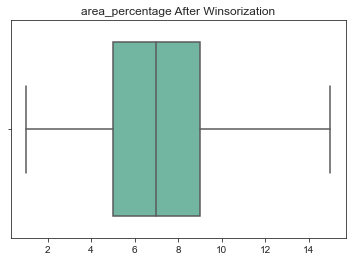

In [48]:
#Data source
name = "area_percentage"
data = train_values[name]

#Before winsorization
sns.boxplot(data)
plt.title("{} Before Winsorization".format(name))
plt.show()

#Winsorization
winsorized_data = winsorize(data,(0, 0.055))

#After winsorization
sns.boxplot(winsorized_data)
plt.title("{} After Winsorization".format(name))
plt.show()

#Replace data in dataset
train_values[name] = winsorized_data

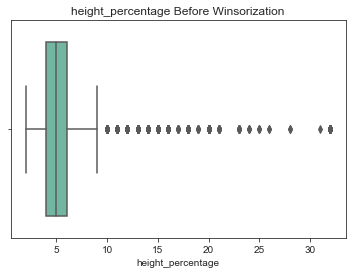

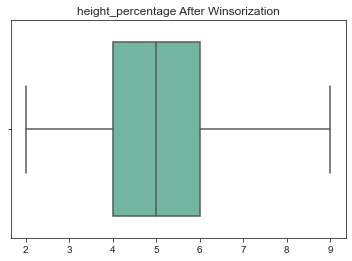

In [49]:
#Data source
name = "height_percentage"
data = train_values[name]

#Before winsorization
sns.boxplot(data)
plt.title("{} Before Winsorization".format(name))
plt.show()

#Winsorization
winsorized_data = winsorize(data,(0, 0.04))

#After winsorization
sns.boxplot(winsorized_data)
plt.title("{} After Winsorization".format(name))
plt.show()

#Replace data in dataset
train_values[name] = winsorized_data

## **Correlations**

In [50]:
train_values.drop(columns=["building_id"], inplace=True)
train_labels.drop(columns=["building_id"], inplace=True)

In [51]:
train_values = pd.get_dummies(train_values, drop_first = True)

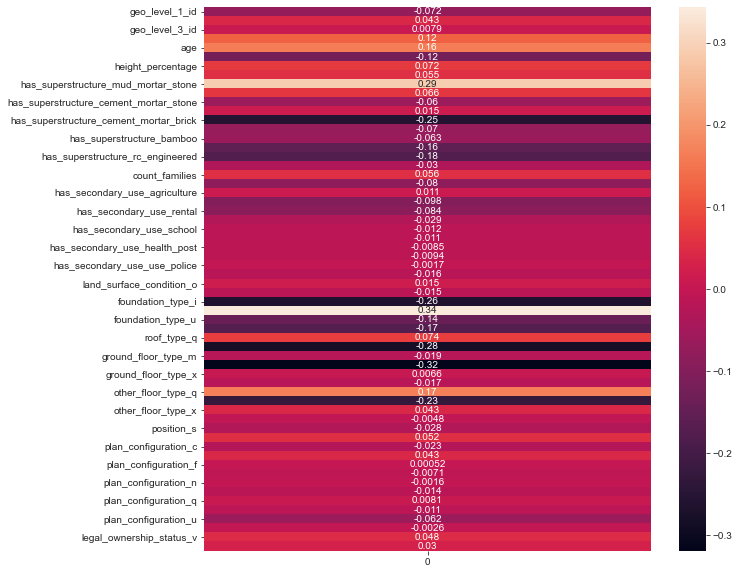

In [52]:
plt.figure(figsize=(10,10))
correlations = train_values.corrwith(train_labels["damage_grade"])
sns.heatmap(pd.DataFrame(correlations), annot=True)
plt.show()

## **Decision Tree vs. Random Forest**

As it was previously mentioned, our dataset is very imbalanced and mainly contains *damage_grade = 2* values. Random forests and decision trees are highly sensitive to outliers, so fixing this issue should be a priority. RandomForestClassifier has a setting that let us deal with class imbalances named "class_weight." By setting class_weight = "balanced", the classes will be automatically weighted inversely proportional to the frequency in which they appear in the dataset. After some trial and error I determined that class_weight = "balanced" will no yield as good results as class_weight = None, because it is very likely that the test data is imbalanced as well.

Let's now compare the score of a single decision tree against that of a random forest. For both models, I'll use the best parameters previously obtained through GridSearchCV (ran in my own machine to speed up the process). I'll use the module time to compare if the added complexity and extra calculation time of the random forest is justified by a better score.

In [ ]:
X = train_values
y = train_labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#Decision Tree
dt = DecisionTreeClassifier(max_features = None,
                            max_depth = 45,
                            min_samples_split = 3,
                            min_samples_leaf = 30,
                            random_state=42)
start_time = time.time()
model = dt.fit(X_train, y_train)
dt_time_fit = time.time() - start_time

#Predictions - Decision Tree
start_time = time.time()
model.predict(X_test)
dt_time_pred = time.time() - start_time
print("Decision Tree")
print("Fit Time: {} seconds".format(dt_time_fit))
print("Prediction Time: {} seconds".format(dt_time_pred))
print("Training Score: {}".format(dt.score(X_train, y_train)))
print("Test Score: {}".format(dt.score(X_test, y_test)))
print("----------------------------------------")

#Random Forest
rf = RandomForestClassifier(max_features = None,
                            max_depth = 45,
                            min_samples_split = 3,
                            min_samples_leaf = 30,
                            random_state=42)
start_time = time.time()
model = rf.fit(X_train, y_train)
rf_time_fit = time.time() - start_time

#Predictions - Decision Tree
start_time = time.time()
model.predict(X_test)
rf_time_pred = time.time() - start_time
print("Random Forest")
print("Fit Time: {} seconds".format(rf_time_fit))
print("Prediction Time: {} seconds".format(rf_time_pred))
print("Training Score: {}".format(rf.score(X_train, y_train)))
print("Test Score: {}".format(rf.score(X_test, y_test)))



Decision Tree
Fit Time: 2.2820241451263428 seconds
Prediction Time: 0.02899932861328125 seconds
Training Score: 0.748661742133538
Test Score: 0.7168895454807084
----------------------------------------


The random forest model took 7x more to be trained and 5x more to make predictions when compared to the single decision tree. The random forest performed better, but no significantly better than a single decision tree. In this scenario, 18 extra seconds of training time is not a big deal for us.

## **Confusion Matrix**

In [ ]:
y_pred = rf.predict(X_test)

data = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 12})
plt.title("Confusion Matrix")
plt.show()

## **Feature Importance**

In [ ]:
results = list(zip(X, rf.feature_importances_))
importance = pd.DataFrame(results, columns = ["Feature", "Importance"])
importance = importance.sort_values(by="Importance", ascending=False)
importance

In [ ]:
importance_10 = importance.head(10)
plot = sns.barplot(x=importance_10["Feature"], y=importance_10["Importance"])
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plt.title("10 Most Important Features")
plt.show()

From the previous plot we can conclude that the geographic region (geo_level_1_id, geo_level_2_id, geo_level_3_id) in which a building exists, and the foundation type "r" are the most important features to determine the damage grade that a building will suffer during an earthquake.

## **Output File**

In [ ]:
test_building_id = test_values["building_id"]
test_values.drop(columns = ["building_id"], inplace=True)

#Outliers
test_values["age"] = winsorize(test_values["age"],(0, 0.05))
test_values["area_percentage"] = winsorize(test_values["area_percentage"],(0, 0.055))
test_values["height_percentage"] = winsorize(test_values["height_percentage"],(0, 0.04))

#Dummies
test_values = pd.get_dummies(test_values, drop_first = True)

#Predictions
predictions = rf.predict(test_values)

#Create Submission File
submission = pd.DataFrame()
submission["building_id"] = test_building_id
submission["damage_grade"] = predictions
submission.head()
submission.to_csv("submission.csv", index=False)

In [ ]:
predictions = rf.predict(test_values)

In [ ]:
submission = pd.DataFrame()
submission["building_id"] = test_building_id
submission["damage_grade"] = predictions
submission.head()
submission.to_csv("submission.csv", index=False)

<a href="submission.csv"> Download File </a>